In [67]:
import os
import shutil
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [34]:
# !unzip ./drive/MyDrive/colab_notebooks/kidney_capstone/train2/neg/train_neg_2.zip -d ./drive/MyDrive/colab_notebooks/kidney_capstone/train2/neg/

In [35]:
# !unzip ./drive/MyDrive/colab_notebooks/kidney_capstone/train2/pos/train_pos2.zip -d ./drive/MyDrive/colab_notebooks/kidney_capstone/train2/pos/

In [36]:
val_dir = f"../data/generated/text_files/val2/"
train_dir = f"../data/generated/text_files/train2/"


In [37]:

if not os.path.exists(os.path.join(val_dir, 'pos')):
    os.mkdir(os.path.join(val_dir, 'pos'))

kf_files = os.listdir(os.path.join(train_dir, 'pos'))
kf_test_files = kf_files[:1000]

for f in kf_test_files:
  shutil.move(f"{train_dir}/pos/{f}", f"{val_dir}/pos/{f}")

In [38]:
if not os.path.exists(os.path.join(val_dir, 'neg')):
  os.mkdir(os.path.join(val_dir, 'neg'))

nkf_files = os.listdir(os.path.join(train_dir, 'neg'))
n_train = len(nkf_files)
nkf_test_files = np.random.choice(nkf_files, 1000, replace = False)

for f in nkf_test_files:
  shutil.move(f"{train_dir}/neg/{f}", f"{val_dir}/neg/{f}")

In [39]:
len(os.listdir(os.path.join(val_dir,'pos')))


1000

In [40]:
len(os.listdir(os.path.join(val_dir,'neg')))

1000

In [ ]:

# if not os.path.exists(val_dir):
#   os.mkdir(val_dir)

# for cat in ['pos', 'neg']:
#   train_files = os.listdir(os.path.join(train_dir, cat))
#   n_train = len(train_files)

#   np.random.seed(2023)
#   val_files = np.random.choice(train_files, size=int(0.1*n_train), replace = False)

#   if not os.path.exists(os.path.join(val_dir, cat)):
#     os.mkdir(os.path.join(val_dir,cat))

#   for f in val_files:
#     shutil.move(f"{train_dir}/{cat}/{f}", f"{val_dir}/{cat}/{f}")

In [ ]:
# !unzip ./drive/MyDrive/colab_notebooks/GloVe/glove.6B.zip -d ./drive/MyDrive/colab_notebooks/GloVe/

Archive:  ./drive/MyDrive/colab_notebooks/GloVe/glove.6B.zip
  inflating: ./drive/MyDrive/colab_notebooks/GloVe/glove.6B.50d.txt  
  inflating: ./drive/MyDrive/colab_notebooks/GloVe/glove.6B.100d.txt  
  inflating: ./drive/MyDrive/colab_notebooks/GloVe/glove.6B.200d.txt  
  inflating: ./drive/MyDrive/colab_notebooks/GloVe/glove.6B.300d.txt  


In [41]:
batch_size = 32
train_ds = keras.utils.text_dataset_from_directory(train_dir, batch_size=batch_size)
val_ds = keras.utils.text_dataset_from_directory(val_dir, batch_size=batch_size)


Found 16696 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [42]:
text_only_train_ds = train_ds.map(lambda x,y : x)

In [43]:
max_length = 100
max_tokens = 20_000

text_vectorization = keras.layers.TextVectorization(
    max_tokens = max_tokens,
    output_mode = 'int',
    output_sequence_length=max_length
)

text_vectorization.adapt(text_only_train_ds)

In [21]:
text_vectorization('30 grams lobster')

<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([ 156,    2, 1962,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int64)>

In [44]:
int_mapper = lambda x,y: (text_vectorization(x), y)


int_train_ds = train_ds.map(int_mapper, num_parallel_calls=4 )
int_val_ds = val_ds.map(int_mapper, num_parallel_calls=4 )

In [49]:
inputs = keras.Input(shape=(None,))
embedded = layers.Embedding(
    input_dim=max_tokens,
    output_dim=256,
    mask_zero = True
)(inputs)
x = layers.Bidirectional(layers.LSTM(32, kernel_regularizer = regularizers.L1L2(l1=0.01, l2=0.01)) )(embedded)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs,outputs)
model.compile(optimizer='rmsprop', loss='bce', metrics=['acc'])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                           

Epoch 1/10
522/522 [==============================] - 38s 65ms/step - loss: 4.2694 - acc: 0.9144 - val_loss: 1.2910 - val_acc: 0.7325
Epoch 2/10
522/522 [==============================] - 29s 55ms/step - loss: 0.4214 - acc: 0.9815 - val_loss: 1.6059 - val_acc: 0.7645
Epoch 3/10
522/522 [==============================] - 28s 54ms/step - loss: 0.3944 - acc: 0.9885 - val_loss: 1.9875 - val_acc: 0.6745
Epoch 4/10
522/522 [==============================] - 29s 55ms/step - loss: 0.3817 - acc: 0.9903 - val_loss: 2.1482 - val_acc: 0.7100
Epoch 5/10
522/522 [==============================] - 28s 53ms/step - loss: 0.3813 - acc: 0.9913 - val_loss: 1.5521 - val_acc: 0.7680
Epoch 6/10
522/522 [==============================] - 28s 53ms/step - loss: 0.3730 - acc: 0.9933 - val_loss: 2.1077 - val_acc: 0.7390
Epoch 7/10
522/522 [==============================] - 28s 54ms/step - loss: 0.3673 - acc: 0.9942 - val_loss: 2.4514 - val_acc: 0.7265
Epoch 8/10
522/522 [==============================] - 27s 51ms

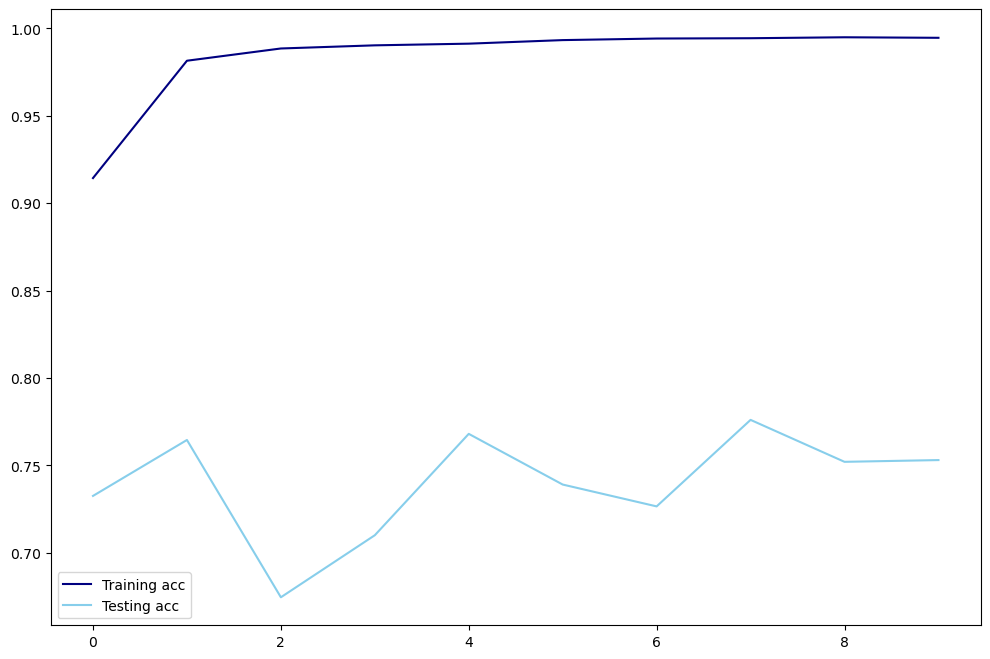

In [46]:
res = model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=10
)


# Visualize loss
train_loss_l1 = res.history['acc']
test_loss_l1 = res.history['val_acc']

plt.figure(figsize=(12, 8))
plt.plot(train_loss_l1, label='Training acc', color='navy')
plt.plot(test_loss_l1, label='Testing acc', color='skyblue')
plt.legend();

In [50]:
!unzip ../data/GloVe/glove.6B.zip -d ../data/GloVe/

Archive:  ../data/GloVe/glove.6B.zip
  inflating: ../data/GloVe/glove.6B.50d.txt  
  inflating: ../data/GloVe/glove.6B.100d.txt  
  inflating: ../data/GloVe/glove.6B.200d.txt  
  inflating: ../data/GloVe/glove.6B.300d.txt  


In [52]:
embeddings_ix = {}

with open('../data/GloVe/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, 'f', sep=' ')
    embeddings_ix[word] = coefs

In [53]:
embedding_dim = 100

vocab = text_vectorization.get_vocabulary()
word_ix = dict(enumerate(vocab))
word_ix = {word: i for i, word in word_ix.items()}

In [54]:
print(word_ix['sodium'])

158


In [55]:
embedding_mx = np.zeros((max_tokens, embedding_dim))

for word, i in word_ix.items():
  if i < max_tokens:
    embed_vector = embeddings_ix.get(word)

  if embed_vector is not None:
    embedding_mx[i, :] = embed_vector

In [56]:
embedding_mx[158, :5]

array([-0.93567002,  0.3705    , -0.11117   , -0.037242  , -0.071873  ])

In [57]:
embeddings_ix['sodium'][:5]

array([-0.93567 ,  0.3705  , -0.11117 , -0.037242, -0.071873],
      dtype=float32)

In [58]:
glove_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_mx),
    trainable=False,
    mask_zero=True
)

In [62]:
inputs = keras.Input(shape=(None,))
embedded = glove_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32, kernel_regularizer = regularizers.L1L2(l1=0.01, l2=0.01)))(embedded)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs,outputs)
model.compile(optimizer='rmsprop', loss='bce', metrics=['acc'])
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 100)         2000000   
                                                                 
 bidirectional_6 (Bidirecti  (None, 64)                34048     
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                           

Epoch 1/100
521/522 [============================>.] - ETA: 0s - loss: 0.4152 - acc: 0.9363
Epoch 1: val_acc improved from -inf to 0.71500, saving model to best_model_2.h5
522/522 [==============================] - 23s 43ms/step - loss: 0.4151 - acc: 0.9363 - val_loss: 1.0460 - val_acc: 0.7150
Epoch 2/100
522/522 [==============================] - ETA: 0s - loss: 0.4163 - acc: 0.9336
Epoch 2: val_acc improved from 0.71500 to 0.84900, saving model to best_model_2.h5
522/522 [==============================] - 22s 43ms/step - loss: 0.4163 - acc: 0.9336 - val_loss: 0.7227 - val_acc: 0.8490
Epoch 3/100
522/522 [==============================] - ETA: 0s - loss: 0.4131 - acc: 0.9353
Epoch 3: val_acc did not improve from 0.84900
522/522 [==============================] - 21s 41ms/step - loss: 0.4131 - acc: 0.9353 - val_loss: 1.2534 - val_acc: 0.6860
Epoch 4/100
522/522 [==============================] - ETA: 0s - loss: 0.4270 - acc: 0.9362
Epoch 4: val_acc did not improve from 0.84900
522/522 

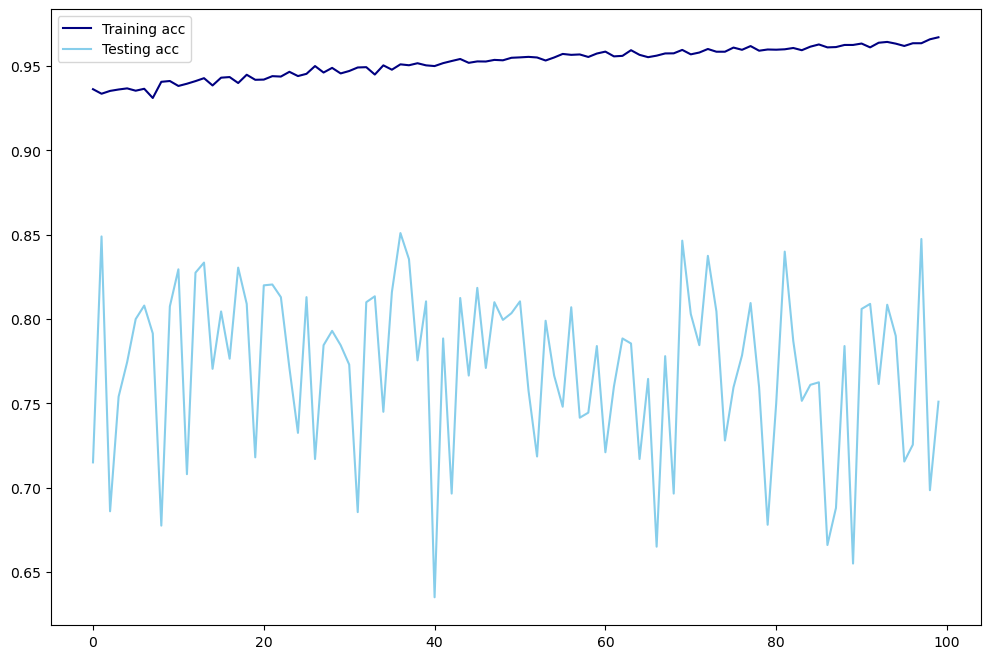

In [70]:
mc = ModelCheckpoint('best_model_2.h5', monitor='val_acc', save_best_only=True, verbose = 1)
# es = EarlyStopping(monitor='acc', mode='max', patience = 3, min_delta = 0.01)
res = model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=100,
    callbacks=[mc]
)

# Visualize loss
train_loss = res.history['acc']
test_loss = res.history['val_acc']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training acc', color='navy')
plt.plot(test_loss, label='Testing acc', color='skyblue')
plt.legend();

### GloVe 42B 300d

In [73]:
embeddings_ix = {}

with open('../data/GloVe/glove.42B.300d.txt', 'r', encoding='utf-8') as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, 'f', sep=' ')
    embeddings_ix[word] = coefs

In [77]:
embedding_dim = 300

vocab = text_vectorization.get_vocabulary()
word_ix = dict(enumerate(vocab))
word_ix = {word: i for i, word in word_ix.items()}

In [78]:
print(word_ix['sodium'])

158


In [79]:
embedding_mx = np.zeros((max_tokens, embedding_dim))

for word, i in word_ix.items():
  if i < max_tokens:
    embed_vector = embeddings_ix.get(word)

  if embed_vector is not None:
    embedding_mx[i, :] = embed_vector

In [80]:
embedding_mx[158, :5]

array([ 0.017378  , -0.51845998,  0.55386001, -0.84460998,  0.17639001])

In [81]:
embeddings_ix['sodium'][:5]

array([ 0.017378, -0.51846 ,  0.55386 , -0.84461 ,  0.17639 ],
      dtype=float32)

In [82]:
glove_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_mx),
    trainable=False,
    mask_zero=True
)

In [83]:
inputs = keras.Input(shape=(None,))
embedded = glove_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32, kernel_regularizer = regularizers.L1L2(l1=0.01, l2=0.01)))(embedded)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs,outputs)
model.compile(optimizer='rmsprop', loss='bce', metrics=['acc'])
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_5 (Embedding)     (None, None, 300)         6000000   
                                                                 
 bidirectional_7 (Bidirecti  (None, 64)                85248     
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                           

Epoch 1/100
522/522 [==============================] - ETA: 0s - loss: 4.1009 - acc: 0.7006
Epoch 1: val_acc improved from -inf to 0.75650, saving model to best_model_3.h5


C:\Users\mikem\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


522/522 [==============================] - 80s 145ms/step - loss: 4.1009 - acc: 0.7006 - val_loss: 1.0335 - val_acc: 0.7565
Epoch 2/100
522/522 [==============================] - ETA: 0s - loss: 0.9094 - acc: 0.8400
Epoch 2: val_acc improved from 0.75650 to 0.81100, saving model to best_model_3.h5
522/522 [==============================] - 80s 153ms/step - loss: 0.9094 - acc: 0.8400 - val_loss: 0.9578 - val_acc: 0.8110
Epoch 3/100
522/522 [==============================] - ETA: 0s - loss: 0.8544 - acc: 0.8769
Epoch 3: val_acc did not improve from 0.81100
522/522 [==============================] - 76s 145ms/step - loss: 0.8544 - acc: 0.8769 - val_loss: 1.0299 - val_acc: 0.7820
Epoch 4/100
522/522 [==============================] - ETA: 0s - loss: 0.8259 - acc: 0.8931
Epoch 4: val_acc did not improve from 0.81100
522/522 [==============================] - 76s 145ms/step - loss: 0.8259 - acc: 0.8931 - val_loss: 1.8699 - val_acc: 0.5505
Epoch 5/100
522/522 [==============================] 

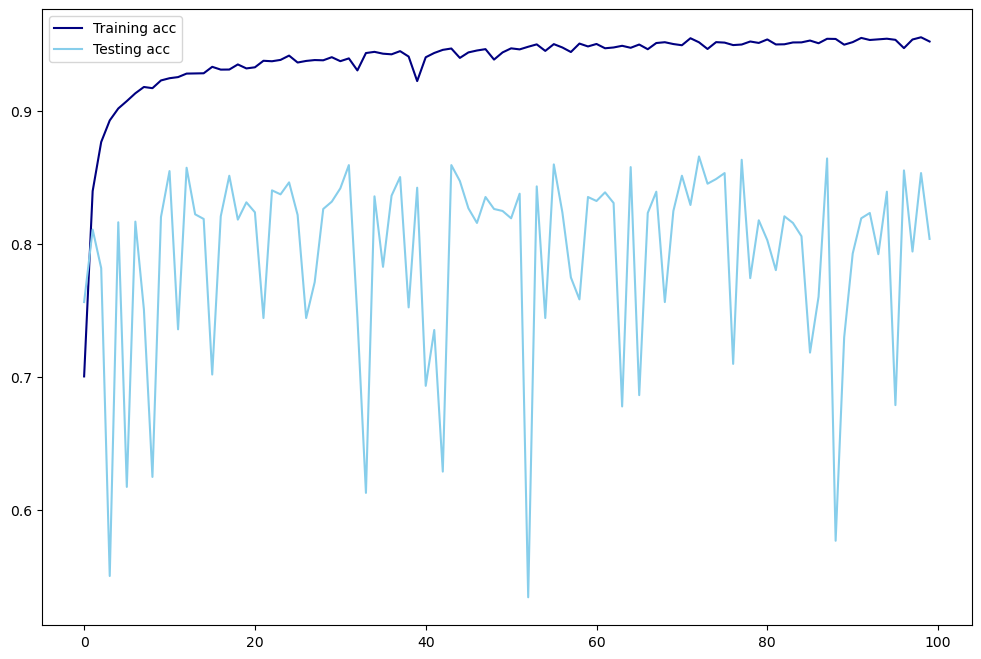

In [84]:
mc = ModelCheckpoint('best_model_3.h5', monitor='val_acc', save_best_only=True, verbose = 1)
# es = EarlyStopping(monitor='acc', mode='max', patience = 3, min_delta = 0.01)
res = model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=100,
    callbacks=[mc]
)

# Visualize loss
train_loss = res.history['acc']
test_loss = res.history['val_acc']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training acc', color='navy')
plt.plot(test_loss, label='Testing acc', color='skyblue')
plt.legend();